# Bayesian Hyper-parameter Optimization

# Prospecting for Gold...

<img src="img/daniel_krige.jpg" style="float: left;">
<img src="img/kriging.png" style="float: right;">


# Problem Statement

We are interested in solving

$ x^* = \underset{x}{\mathrm{argmin}} f(x)  $

under the constraints that

$ f $ is a black box for which no closed form is known (nor its gradients);
 
$ f $ is expensive to evaluate;

and evaluations of $ y = f(x) $ may be noisy.

**Finding**: Under these constraints, *Bayesian Optimization* is a good fit.

# Bayesian Optimization Loop

For $ t = 1 : T $:

  1. Given observations $ (x_i, y_i = f(x_i)) $ for $i = 1 : t $, build a probability model (aka *surrogate model*) for the objective $f$ .
  2. Optimize a cheap acquisition/utility function $u$ based on the posterior distribution of the surrogate model for sampling the next point:
  
  $ x_{t+1} = \underset{x}{\mathrm{argmin}} \ u(x) $
  
  Surrogate model needs to provide *uncertainty* estimates to balance exploration against exploitation.
  
  3. Sample the next observation $ y_{t+1} = f(x_{t+1})$
  
  
This procedure will build a sequence of models that model the relationship between the hyper-parameters and the performance metric hence its also called **Sequential Model-based Optimization**.

# Acquisition Functions
Acquisition functions $u(x)$ specify which sample $x$ should be tried next:

  * Lower confidence bound: $\mu_{SM} + \kappa \sigma_{SM}$
  * Expected improvement
  * Probability of improvement

In most cases, acquisition functions provide knobs (e.g., $\kappa$) for controlling the exploration-exploitation trade-off. 
  - Search in regions where $\mu_{SM}$ is high (exploitation) 
  - Probe regions where uncertainty $\kappa \sigma_{SM}$ is high (exploration)
  
We can use the acquisition function to encode additional constraints.
  - Time to evaluate the objective $f$ .

# Surrogate Model

### Gaussian Process Regression

<img src="img/sm-gp.png" width=300 style="float: right;">

  * Can provide a full posterior (not just $\mu_{GP}$ and $\sigma_{GP}$)
  * RBF kernel well suited for smooth functions
  * Can learn from few data points
<div style="clear: both;"/>

### Tree-ensembles

<img src="img/sm-gbrt.png" width=300 style="float: right;">

  * GBM requires quantile regression to provide uncertainty estimate $\sigma$ 
  * RandomForest uses variance of leaves for $\sigma$ 
  * Tree methods better suited for discrete parameters


# Toy Problem

<img src="img/skopt-true-fn.png">

# Toy Problem cont'

Left column shows the true function (unknown), sampled points, and current model.

Right column shows the value of the utility function and the next point to sample.
<img src="img/skopt-steps.png">

# Bayesian Optimization with [Scikit-optimize](https://scikit-optimize.github.io/)

Populating the interactive namespace from numpy and matplotlib


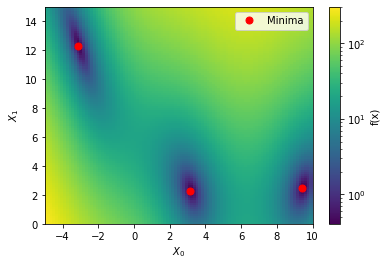

In [1]:
%pylab inline

from skopt.benchmarks import branin as branin
import utils

utils.plot_branin()

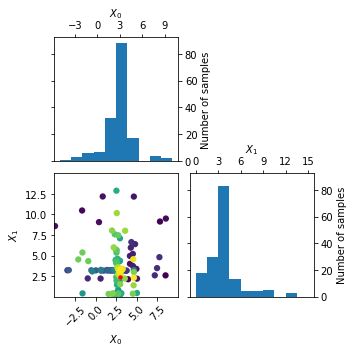

In [2]:
from skopt.plots import plot_evaluations
from skopt import forest_minimize


bounds = [(-5.0, 10.0), (0.0, 15.0)]
n_calls = 160

forest_res = forest_minimize(branin, bounds, n_calls=n_calls, base_estimator="ET",
                             random_state=4)

_ = plot_evaluations(forest_res, bins=10)

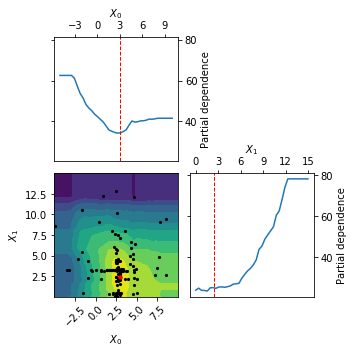

In [3]:
from skopt.plots import plot_objective

# plot partial-dependency between the objective function and each dimension
_ = plot_objective(forest_res)

# BayesSearchCV

`skopt` provides an implementation of sklearn's `BaseSearchCV` class:

In [8]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = load_digits(10, True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

In [5]:
import sklearn
print('sklearn', sklearn.__version__)
import skopt
print('skopt', skopt.__version__)

sklearn 0.22.1
skopt 0.7.4


In [8]:
# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'degree': Integer(1, 8),  # integer valued parameter
        'kernel': Categorical(['linear', 'poly', 'rbf']),  # categorical parameter
    },
    optimizer_kwargs={'base_estimator': 'RF'},
    n_iter=32,
    cv=3,
    random_state=0
)

In [9]:
opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.9851521900519673
test score: 0.9822222222222222


In [10]:
opt.best_params_

OrderedDict([('C', 2.744180043270382),
             ('degree', 4),
             ('gamma', 0.16763476700273122),
             ('kernel', 'poly')])

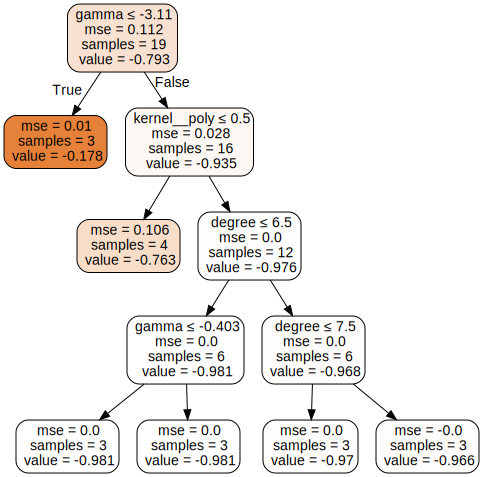

In [11]:
utils.plot_sklearn_tree(opt.optimizers_[0].models[-1].estimators_[0],
    ['C', 'degree', 'gamma', 'kernel__linear', 'kernel__poly', 'kernel__rbf'])

# Exercise 2.2.1

Run `BayesSearchCV` on the `boston_housing` dataset. 

Use the same hyper-parameter ranges that we used in 1.4 for `RandomizedSearchCV`.

### Note

`BayesSearchCV` doesnt take `scipy.stats` distribution objects; distributions need to be encoded either as tuples `(start, end, distribution_type)` or a list. 

Example: `(1, 100, 'log-uniform')`

Display the searched points with pandas:
```python
gs = BayesSearchCV(..).fit(..)
pd.DataFrame(gs.cv_results_)
```

In [10]:
import scipy

from sklearn.datasets import load_boston
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from skopt import BayesSearchCV

data = load_boston()
X = data.data
y = data.target
X = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

est = SVR()

param_grid = {
    'C': (1, 100, 'log-uniform'), 
    'gamma': (0.001, 1.0, 'log-uniform'), 
    'kernel': ['rbf', 'linear']
}

gs = BayesSearchCV(est, param_grid, cv=3, scoring='neg_mean_absolute_error', 
                   n_iter=12, n_jobs=-1, verbose=10, random_state=0)
gs.fit(X_train, y_train)

print("best params: {}".format(gs.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, gs.predict(X_test)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


best params: OrderedDict([('C', 100), ('gamma', 1.0), ('kernel', 'rbf')])
model score: 2.397


# Advanced features of `skopt`

### Acquisition function taking into account function eval time
`acq_func='EIps'` will build two models, one surrogate model for the objective function and one model to predict the time a function evaluation takes. This is taken into account where to probe/search next.

### Parallelization
Due to the sequential nature of the Bayesian Optimization loop parallelization is tricky. `skopt` allows you to probe multiple points per iteration. 

### Callbacks &  Check-pointing
Callbacks can be used to implement check-pointing (pause/resume) and interrupts. 

```python
def on_step(optim_result):
    skopt.dump(optim_result, 'result.pkl')

searchcv = BayesSearchCV(...)
searchcv.fit(X, y, callback=on_step)
```

# When to use BO over RS/GS?

Bayesian Optimization usually yields better final performance than Random Search.

Anytime performance of BO not necessarily better than RS.


<div  style="float: right;" >
<img src="img/automl-bo-rs.png">
<div style="text-align: right">Source: A. Biedenkapp, "BOHB Robust and Efficient Hyperparameter Optimization at Scale."</div>
</div>
 

# Conclusion

  * Hyper-parameter tuning makes a significant difference in accuracy of trained models.
  * 20-10 years ago hyper-parameter tuning was considerend an art/craft:
    - Neural Networks: nr of layers, hidden units, activation functions, optimizer settings, ...
    - Part of the coming-of-age of an ML practioneer.
  * Now, the tools exist to make some of this knowledge obsolete / less important.
  * (Bayesian) Hyper-parameter optimization is the most practical form of AML that is readily available today.
    - Many open source solutions exist:
      - [spearmint](https://github.com/HIPS/Spearmint)
      - [hyperopt](http://hyperopt.github.io/hyperopt/)
      - [skopt](https://scikit-optimize.github.io/)